In [ ]:
from utils.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils.LSTM import *
import yaml

In [2]:
def final_results(results, param_1, param_2):
    df_results = pd.DataFrame(results)
    pivot = df_results.pivot(index=param_1, columns=param_2, values="mse")

    # Normalización global (toda la grilla)
    min_val = pivot.min().min()
    max_val = pivot.max().max()
    pivot_norm = (pivot - min_val) / (max_val - min_val)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(pivot_norm, cmap="coolwarm", aspect="auto")

    plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns)
    plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
    plt.xlabel(param_2)
    plt.ylabel(param_1)
    plt.title("MSE normalizado globalmente")

    cbar = plt.colorbar(im)
    cbar.set_label("MSE Normalizado (Global)", rotation=270, labelpad=15)

    # Mostrar los valores reales (no normalizados) dentro de las celdas
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            plt.text(j, i, f"{pivot.iloc[i, j]:.4f}",
                    ha="center", va="center", color="white" if pivot_norm.iloc[i, j] > 0.5 else "white")

    plt.tight_layout()
    plt.show()

    best_result = {"mse": float("inf")}
    for res in results:
        if res["mse"] < best_result["mse"]:
            best_result = res

    print(f"Best results:\nMSE = {best_result["mse"]}\n{param_1} = {best_result[param_1]} \n{param_2} = {best_result[param_2]}")

In [3]:
# with open("config.yaml", 'r') as file:
#             config_data = yaml.safe_load(file)
            
# dfs = dowload_tickers(config_data)

stock = "AMD"

df = pd.read_csv(f"./prices/{stock}_prices.csv", index_col=0, parse_dates=True)

In [4]:
start_day    = "2025-01-01"

horizon_days = 50                           # cantidad de días hábiles a predecir
training_years = 2                         # años previos para entrenar y predecir cada día

feat_cols = ["Close"]

In [5]:
# TRAINING
##########
results = []
for bs in [21, 16, 11, 5]:
    for lr in [0.01, 0.005, 0.001]:
        res = walk_forward_predict(     LSTMRegressor,
                                        df, 
                                        start_day, 
                                        horizon_days,
                                        training_years=training_years,
                                        feat_cols=feat_cols,

                                        W=50,
                                        
                                        hidden_size=64, 
                                        num_layers=2, 
                                        dropout=0.1,
                                        hit_coef=0.5,
                                        batch_size=bs, 
                                        epochs=30, 
                                        lr=lr,

                                        patience=5,
                                        loss_validation=True,
                                        
                                        torch_seed=0
                                    )
        res_df = res[0]
        mse = float(np.mean((res_df["y_pred_norm"] - res_df["y_true_norm"])**2))
        print(f"Batch = {bs} | Alpha = {lr} | MSE = {mse}")
        results.append({
            "stock": stock,
            "bs":bs,
            "lr":lr,
            "res":res,
            "mse":mse
        })

Processing test days:   0%|          | 0/50 [00:00<?, ?it/s]

Processing test days: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Batch = 21 | Alpha = 0.01 | MSE = 0.001501458443267564


Processing test days: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Batch = 21 | Alpha = 0.005 | MSE = 0.0011895227281797213


Processing test days: 100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


Batch = 21 | Alpha = 0.001 | MSE = 0.001896461358815282


Processing test days: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it]


Batch = 16 | Alpha = 0.01 | MSE = 0.0013025759079817866


Processing test days: 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Batch = 16 | Alpha = 0.005 | MSE = 0.0009076819893967036


Processing test days: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


Batch = 16 | Alpha = 0.001 | MSE = 0.0022876327882448365


Processing test days: 100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Batch = 11 | Alpha = 0.01 | MSE = 0.0010312444020256475


Processing test days: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Batch = 11 | Alpha = 0.005 | MSE = 0.0008682883640183757


Processing test days: 100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


Batch = 11 | Alpha = 0.001 | MSE = 0.0010299810797867782


Processing test days: 100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


Batch = 5 | Alpha = 0.01 | MSE = 0.0007602716718960362


Processing test days: 100%|██████████| 50/50 [02:33<00:00,  3.07s/it]


Batch = 5 | Alpha = 0.005 | MSE = 0.0008348643953750717


Processing test days: 100%|██████████| 50/50 [03:34<00:00,  4.29s/it]

Batch = 5 | Alpha = 0.001 | MSE = 0.000913392177405157


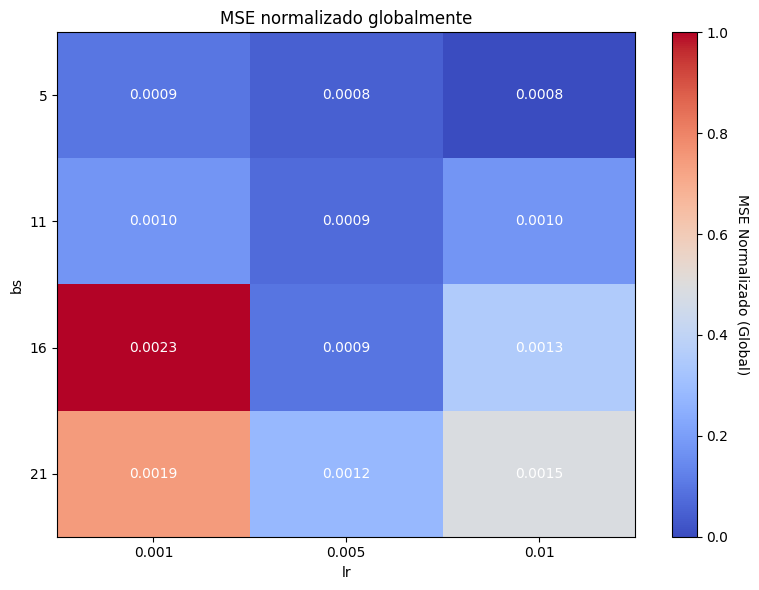

Best results:
MSE = 0.0007602716718960362
bs = 5 
lr = 0.01


In [6]:
final_results(results, "bs", "lr")

In [7]:
# TRAINING
##########
results2 = []
for hidden_size in [16, 32, 64, 128]:
    for dropout in [0.1, 0.25, 0.4, 0.5]:
        res = walk_forward_predict(     LSTMRegressor,
                                        df, 
                                        start_day, 
                                        horizon_days,
                                        training_years=training_years,
                                        feat_cols=feat_cols,

                                        W=50,
                                        
                                        hidden_size=hidden_size, 
                                        num_layers=2, 
                                        dropout=dropout,
                                        hit_coef=0.5,
                                        batch_size=5, 
                                        epochs=30, 
                                        lr=0.01,

                                        patience=5,
                                        loss_validation=True,
                                        
                                        torch_seed=0
                                    )
        
        res_df = res[0]
        mse = float(np.mean((res_df["y_pred_norm"] - res_df["y_true_norm"])**2))
        print(f"hidden_size = {hidden_size} | dropout = {dropout} | MSE = {mse}")
        results2.append({
            "stock": stock,
            "hidden_size":hidden_size,
            "dropout":dropout,
            "res":res,
            "mse":mse
        })

Processing test days: 100%|██████████| 50/50 [03:21<00:00,  4.02s/it]


hidden_size = 16 | dropout = 0.1 | MSE = 0.000934753322407155


Processing test days: 100%|██████████| 50/50 [03:18<00:00,  3.97s/it]


hidden_size = 16 | dropout = 0.25 | MSE = 0.0010587928183565575


Processing test days: 100%|██████████| 50/50 [03:11<00:00,  3.84s/it]


hidden_size = 16 | dropout = 0.4 | MSE = 0.0012229397680398194


Processing test days: 100%|██████████| 50/50 [03:09<00:00,  3.79s/it]


hidden_size = 16 | dropout = 0.5 | MSE = 0.0017447696136356986


Processing test days: 100%|██████████| 50/50 [03:11<00:00,  3.83s/it]


hidden_size = 32 | dropout = 0.1 | MSE = 0.000911428230146137


Processing test days: 100%|██████████| 50/50 [03:07<00:00,  3.76s/it]


hidden_size = 32 | dropout = 0.25 | MSE = 0.001024029742719491


Processing test days: 100%|██████████| 50/50 [02:32<00:00,  3.06s/it]


hidden_size = 32 | dropout = 0.4 | MSE = 0.0012762893023279928


Processing test days: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it]


hidden_size = 32 | dropout = 0.5 | MSE = 0.005956828883328703


Processing test days: 100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


hidden_size = 64 | dropout = 0.1 | MSE = 0.0007602716718960362


Processing test days: 100%|██████████| 50/50 [03:08<00:00,  3.78s/it]


hidden_size = 64 | dropout = 0.25 | MSE = 0.0016071579811286795


Processing test days: 100%|██████████| 50/50 [02:38<00:00,  3.17s/it]


hidden_size = 64 | dropout = 0.4 | MSE = 0.002963427533196958


Processing test days: 100%|██████████| 50/50 [02:46<00:00,  3.33s/it]


hidden_size = 64 | dropout = 0.5 | MSE = 0.0022530328259205397


Processing test days: 100%|██████████| 50/50 [02:39<00:00,  3.18s/it]


hidden_size = 128 | dropout = 0.1 | MSE = 0.012420136205931824


Processing test days: 100%|██████████| 50/50 [02:25<00:00,  2.92s/it]


hidden_size = 128 | dropout = 0.25 | MSE = 0.016131174130313168


Processing test days: 100%|██████████| 50/50 [02:38<00:00,  3.17s/it]


hidden_size = 128 | dropout = 0.4 | MSE = 0.017525698663871513


Processing test days: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it]

hidden_size = 128 | dropout = 0.5 | MSE = 0.013424626529525587


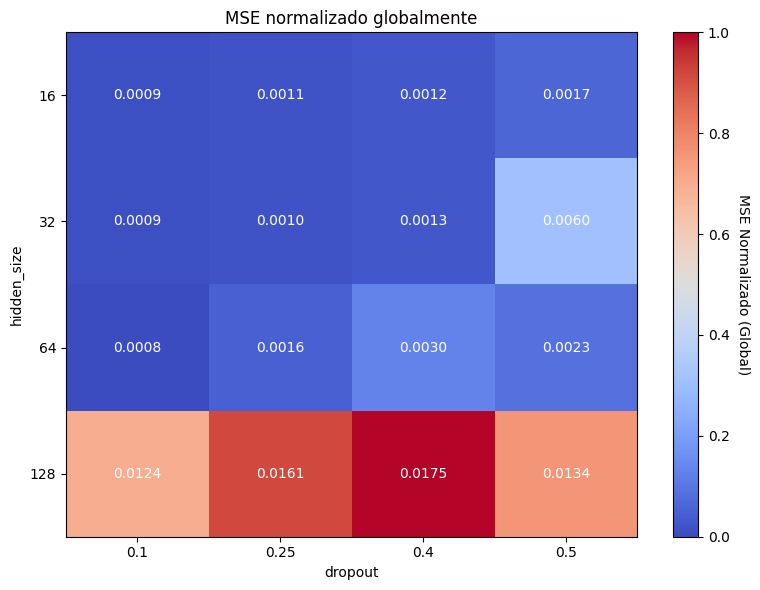

Best results:
MSE = 0.0007602716718960362
hidden_size = 64 
dropout = 0.1


In [8]:
final_results(results2, "hidden_size", "dropout")

In [ ]:
# TRAINING
##########

res = walk_forward_predict(     LSTMRegressor,
                                df, 
                                start_day, 
                                horizon_days,
                                training_years=training_years,
                                feat_cols=feat_cols,

                                W=50,
                                
                                hidden_size=hidden_size, 
                                num_layers=2, 
                                dropout=dropout,
                                hit_coef=0.5,
                                batch_size=5, 
                                epochs=30, 
                                lr=0.01,

                                patience=5,
                                loss_validation=True,
                                
                                torch_seed=0
                            )

Running in cuda...
Test days: 50 days, from 2025-01-02 to 2025-03-17


Processing test days: 100%|██████████| 50/50 [06:28<00:00,  7.76s/it]


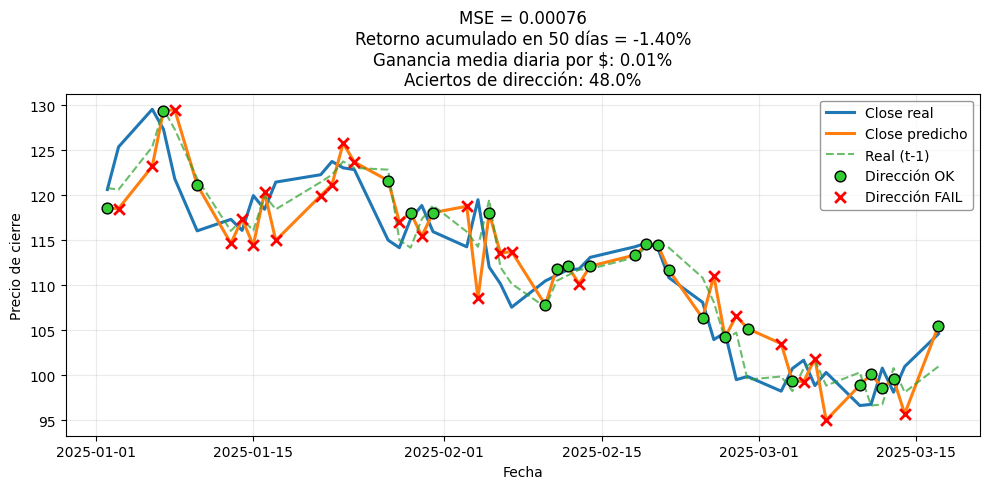

In [39]:
show_results_forecasting(res)

In [40]:
from matplotlib.ticker import FuncFormatter

def show_mse_vs_volume(
        res,
        mse_on: str = "norm",   # "norm" (default) usa y_*_norm; "raw" usa y_* reales
        smooth: int | None = None  # p.ej. 3, 5 o 7 para media móvil del MSE
    ):
    """
    Superpone MSE diario vs Volumen real por día usando el resultado `res`.
    - Eje izquierdo: MSE diario (por punto).
    - Eje derecho: Volumen real (desde df).

    Parámetros
    ----------
    res : tuple
        res[0] = res_df con columnas: y_true, y_pred, y_true_norm, y_pred_norm
        res[1] = dict con al menos data["df"] (serie original, con 'Volume')
    mse_on : {"norm", "raw"}
        - "norm": MSE calculado como (y_pred_norm - y_true_norm)^2 (recomendado).
        - "raw":  MSE calculado como (y_pred - y_true)^2.
    smooth : int | None
        Tamaño de ventana para media móvil del MSE. None para sin suavizado.
    """
    # Unpack
    res_df = res[0]
    data = res[1]
    df = data["df"]

    # Elegir columnas según mse_on
    if mse_on == "norm":
        if not {"y_true_norm", "y_pred_norm"}.issubset(res_df.columns):
            raise ValueError("Faltan columnas 'y_true_norm'/'y_pred_norm' en res_df.")
        err = (res_df["y_pred_norm"] - res_df["y_true_norm"])**2
        mse_label = "MSE diario (norm)"
    elif mse_on == "raw":
        if not {"y_true", "y_pred"}.issubset(res_df.columns):
            raise ValueError("Faltan columnas 'y_true'/'y_pred' en res_df.")
        err = (res_df["y_pred"] - res_df["y_true"])**2
        mse_label = "MSE diario (raw)"
    else:
        raise ValueError("mse_on debe ser 'norm' o 'raw'.")

    # Suavizado opcional
    if smooth and smooth > 1:
        err_plot = err.rolling(smooth, min_periods=1).mean()
        mse_label += f" (MA{smooth})"
    else:
        err_plot = err

    # Localizar la columna de Volumen (tolerante a nombres)
    vol_candidates = [c for c in df.columns if c.lower() in ("volume", "vol")]
    if not vol_candidates:
        raise ValueError("No se encontró columna de volumen en df (ej: 'Volume' o 'Vol').")
    vol_col = vol_candidates[0]

    # Alinear el volumen al mismo índice del período de test (res_df.index)
    vol = df.loc[res_df.index, vol_col].astype(float)

    # Correlación simple (Pearson) entre MSE diario y Volumen
    # (dropna por si hubiera faltantes)
    aligned = pd.concat([err, vol], axis=1, keys=["mse", "vol"]).dropna()
    corr = aligned["mse"].corr(aligned["vol"])

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(11, 6))
    ax2 = ax1.twinx()

    # Volumen como barras (eje derecho)
    ax2.bar(res_df.index, vol, alpha=0.25, width=1.0, label="Volumen", edgecolor="none")

    # MSE como línea (eje izquierdo)
    ax1.plot(res_df.index, err_plot, lw=2.0, label=mse_label)

    # Etiquetas y títulos
    ax1.set_xlabel("Fecha")
    ax1.set_ylabel("MSE por día")
    ax2.set_ylabel(f"Volumen ({vol_col})")

    title_corr = f"Correlación Pearson(MSE, Vol) = {corr:.3f}" if np.isfinite(corr) else "Correlación no disponible"
    ax1.set_title(f"MSE diario vs Volumen — {title_corr}")

    # Formateo del volumen (miles, millones, etc.)
    def human_readable(x, _):
        # formato corto: 1.2K, 3.4M, 5.6B
        abs_x = abs(x)
        if abs_x >= 1e9:  return f"{x/1e9:.1f}B"
        if abs_x >= 1e6:  return f"{x/1e6:.1f}M"
        if abs_x >= 1e3:  return f"{x/1e3:.1f}K"
        return f"{x:.0f}"
    ax2.yaxis.set_major_formatter(FuncFormatter(human_readable))

    # Leyendas
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, frameon=True)

    ax1.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()


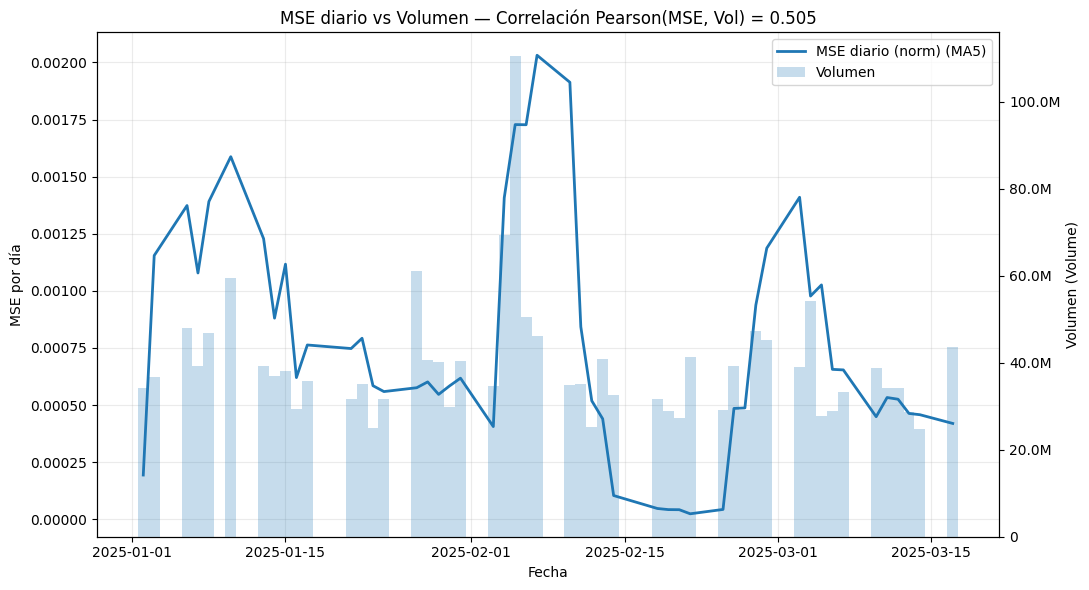

In [41]:
# MSE en escala normalizada (como tu métrica principal)
show_mse_vs_volume(res, mse_on="norm", smooth=5)

# Si quisieras comparar en valores reales:
# show_mse_vs_volume(res, mse_on="raw", smooth=3)
